In [1]:
import os
from dotenv import load_dotenv

# -------------------------------
# Load Environment Variables
# -------------------------------
load_dotenv()

env_vars = ["OPENAI_API_KEY", "TAVILY_API_KEY", "LANGSMITH_API_KEY", "LANGCHAIN_PROJECT"]
for var in env_vars:
    value = os.getenv(var)
    if value is None:
        print(f"⚠️ Warning: {var} not found in .env")
    else:
        os.environ[var] = value


In [2]:
# -------------------------------
# Load PDFs using PyMuPDFLoader
# -------------------------------
from langchain_community.document_loaders import PyMuPDFLoader

PDF_FOLDER = "docs/"
docs = []

for file_name in os.listdir(PDF_FOLDER):
    if file_name.endswith(".pdf"):
        file_path = os.path.join(PDF_FOLDER, file_name)
        try:
            loader = PyMuPDFLoader(file_path)
            loaded_docs = loader.load()
            docs.extend(loaded_docs)
            print(f"✅ Loaded '{file_name}' with {len(loaded_docs)} pages")
        except Exception as e:
            print(f"❌ Error loading '{file_name}': {e}")

print(f"📄 Total pages loaded: {len(docs)}")

c:\Users\heman\Desktop\Agentic AI Projects\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Loaded 'Agentic AI Frameworks Architectures Protocols and Design Challenges.pdf' with 8 pages
✅ Loaded 'Agentic Web  Weaving the Next Web with AI Agents.pdf' with 76 pages
✅ Loaded 'AI Agents vs. Agentic AI A Conceptual taxonomy, applications and challenges.pdf' with 30 pages
✅ Loaded 'AI in data science education experiences from the classroom.pdf' with 6 pages
✅ Loaded 'From AI for Science to Agentic Science.pdf' with 74 pages
✅ Loaded 'Small Language Models are the Future of Agentic AI.pdf' with 17 pages
📄 Total pages loaded: 211


In [3]:
# -------------------------------
# Split Text into Chunks
# -------------------------------
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    separators=["\n\n", "\n", " ", ""]
)

split_docs = text_splitter.split_documents(docs)
print(f"📄 Total chunks after splitting: {len(split_docs)}")

📄 Total chunks after splitting: 1113


In [ ]:
# -------------------------------
# Create Embeddings + Vector Store (Chroma)
# -------------------------------
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
persist_directory = "./chroma_db_research_agent"

vector_store = Chroma.from_documents(
    collection_name="research_docs",
    documents=split_docs,
    embedding=embeddings,
    persist_directory=persist_directory,
)

print(f"✅ Vector store created with {vector_store._collection.count()} vectors")

✅ Vector store created with 4452 vectors


In [5]:
# -------------------------------
# Build Hybrid Retriever (Semantic + MMR)
# -------------------------------
from langchain_classic.retrievers.ensemble import EnsembleRetriever

semantic_retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

mmr_retriever = vector_store.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 5, "fetch_k": 20}
)

hybrid_retriever = EnsembleRetriever(
    retrievers=[semantic_retriever, mmr_retriever],
    weights=[0.7, 0.3]
)

In [6]:
# -------------------------------
# Initialize Models (Cheap & Efficient)
# -------------------------------
from langchain_openai import ChatOpenAI

# Primary model for generation
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.4)

# Cheaper model for evaluation
eval_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

In [7]:
# -------------------------------
# Simplified Query Enhancement (1-step)
# -------------------------------
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

query_enhance_prompt = PromptTemplate.from_template("""
You are enhancing a research query to improve document retrieval.
Rewrite the query by:
- Adding synonyms and related technical terms
- Expanding acronyms or key ideas
- Adding one short, factual sentence that provides hypothetical context

Query: "{query}"

Enhanced query:
""")

query_enhance_chain = query_enhance_prompt | llm | StrOutputParser()

In [8]:
# -------------------------------
# RAG Answer Generation
# -------------------------------
from langchain_classic.chains.combine_documents import create_stuff_documents_chain

answer_prompt = PromptTemplate.from_template("""
You are an expert AI research assistant.
Write a structured research-style answer using the provided context.

--- Context Start ---
{context}
--- Context End ---

Question: {input}

Your response must follow this structure:

**Title:**  
**Abstract:**  
**Background:**  
**Analysis:**  
**Implications / Risks:**  
**Conclusion:**  
**References:**  

Use a clear, factual tone. Avoid speculation.
""")

document_chain = create_stuff_documents_chain(llm=llm, prompt=answer_prompt)

In [9]:
# -------------------------------
# Hybrid RAG Pipeline
# -------------------------------
from langchain_core.runnables import RunnableLambda, RunnablePassthrough, RunnableParallel

rag_pipeline = (
    RunnableParallel(
        enhanced_query=query_enhance_chain,
        original_query=RunnablePassthrough()
    )
    | RunnableLambda(lambda x: {
        "context": hybrid_retriever.invoke(x["enhanced_query"]),
        "input": x["original_query"]
    })
    | document_chain
)

In [10]:
# -------------------------------
# Define Agent State
# -------------------------------
from typing import TypedDict, Optional

class ResearchState(TypedDict):
    query: str
    report: Optional[str]
    score: Optional[int]
    feedback: Optional[str]
    attempts: Optional[int]

In [11]:
# -------------------------------
# Node 1 - Generate Report
# -------------------------------
def generate_report(state: ResearchState) -> ResearchState:
    query = state["query"]
    print(f"🧠 Generating report for query: {query}")

    report = rag_pipeline.invoke(query)
    print("✅ Report generated successfully.")

    return {**state, "report": report}

In [12]:
# -------------------------------
# Node 2 - Evaluate Report
# -------------------------------
evaluation_prompt = PromptTemplate.from_template("""
You are an evaluator assessing research report clarity.

Please provide:
1. A short explanation (2–3 sentences) of how understandable it is.
2. A readability score from 1–10:
   - 1 = very complex and academic
   - 10 = clear and simple to understand

Report:
---
{report}
---

Format:
Explanation: <your explanation>
Score: <number between 1 and 10>
""")

evaluation_chain = evaluation_prompt | eval_llm | StrOutputParser()

import re
def evaluate_report(state: ResearchState) -> ResearchState:
    report = state.get("report", "")
    if not report:
        print("⚠️ No report to evaluate.")
        return state

    print("🧩 Evaluating report readability...")
    evaluation_text = evaluation_chain.invoke({"report": report})

    score_match = re.search(r"Score:\s*(\d+)", evaluation_text)
    score = int(score_match.group(1)) if score_match else None

    print(f"✅ Evaluation complete. Score: {score}")
    return {**state, "score": score, "feedback": evaluation_text}

In [13]:
# -------------------------------
# Node 3 - Supervisor Logic
# -------------------------------
def supervisor(state: ResearchState) -> str:
    score = state.get("score", None)
    state["attempts"] = state.get("attempts", 0) + 1

    if score is None:
        print("⚠️ No score found — regenerating report.")
        return "generate_report"

    print(f"🧠 Supervisor reviewing score {score}, attempt {state['attempts']}")

    if score < 7 and state["attempts"] < 2:
        print("🔁 Score below 7 — regenerating report.")
        return "generate_report"
    else:
        print("✅ Score acceptable or max attempts reached — continuing.")
        return "check_hallucination"

In [14]:
# -------------------------------
# Node 4 - Check Hallucination (Placeholder)
# -------------------------------
def check_hallucination(state: ResearchState) -> ResearchState:
    print("🤖 Checking hallucinations... (future feature)")
    return state

In [15]:
# -------------------------------
# Build LangGraph
# -------------------------------
from langgraph.graph import StateGraph, START, END

graph = StateGraph(ResearchState)
graph.add_node("generate_report", generate_report)
graph.add_node("evaluate_report", evaluate_report)
graph.add_node("supervisor", supervisor)
graph.add_node("check_hallucination", check_hallucination)

graph.add_edge(START, "generate_report")
graph.add_edge("generate_report", "evaluate_report")

graph.add_conditional_edges(
    "evaluate_report",
    supervisor,
    {
        "generate_report": "generate_report",
        "check_hallucination": "check_hallucination"
    }
)

graph.add_edge("check_hallucination", END)
app = graph.compile()

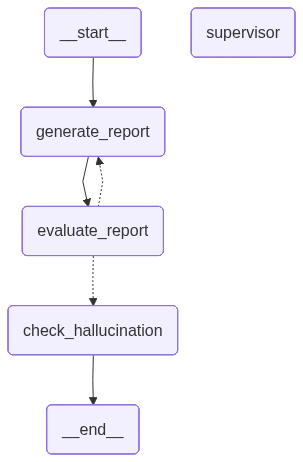

In [16]:
# -------------------------------
# Visualize the graph
# -------------------------------
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
# -------------------------------
# Run Example Query
# -------------------------------
query = {"query": "How does Agentic AI differ from traditional AI?"}
answer = app.invoke(query)
print("\n🧾 Final Output:\n", answer)


🧠 Generating report for query: How does Agentic AI differ from traditional AI?
✅ Report generated successfully.
🧩 Evaluating report readability...
✅ Evaluation complete. Score: 8
🧠 Supervisor reviewing score 8, attempt 1
✅ Score acceptable or max attempts reached — continuing.
🤖 Checking hallucinations... (future feature)

🧾 Final Output:
 {'query': 'How does Agentic AI differ from traditional AI?', 'report': '**Title:**  \nDifferentiating Agentic AI from Traditional AI: A Structural and Functional Analysis\n\n**Abstract:**  \nThis paper examines the distinctions between traditional AI and Agentic AI, highlighting their architectural differences, operational capabilities, and levels of autonomy. By analyzing the evolution from Generative AI to AI Agents and ultimately to Agentic AI, we elucidate the enhanced collaborative and adaptive functionalities of Agentic AI systems. This analysis underscores the implications of these differences for future AI applications and the potential risks

In [20]:
import pprint
pprint.pprint(f"Feedback : {answer['feedback']} /n")
pprint.pprint(f"Score : {answer['score']} /n")
pprint.pprint(f"Query : {answer['query']} /n")
pprint.pprint(f"Report : {answer['report']} /n")


('Feedback : Explanation: The report provides a detailed comparison between '
 'traditional AI and Agentic AI, outlining their structural and functional '
 'differences in a clear and organized manner. The language used is technical '
 'but accessible, making it understandable for readers with some background '
 'knowledge in AI.\n'
 'Score: 8 /n')
'Score : 8 /n'
'Query : How does Agentic AI differ from traditional AI? /n'
('Report : **Title:**  \n'
 'Differentiating Agentic AI from Traditional AI: A Structural and Functional '
 'Analysis\n'
 '\n'
 '**Abstract:**  \n'
 'This paper examines the distinctions between traditional AI and Agentic AI, '
 'highlighting their architectural differences, operational capabilities, and '
 'levels of autonomy. By analyzing the evolution from Generative AI to AI '
 'Agents and ultimately to Agentic AI, we elucidate the enhanced collaborative '
 'and adaptive functionalities of Agentic AI systems. This analysis '
 'underscores the implications of thes